### Imports

In [7]:
import os
import pandas as pd
import numpy as np
from numpy.random import beta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [16]:
from transform_ps.etl.data_type import DataFactory
from transform_ps.etl.util import clear_cwd_cache
clear_cwd_cache()

cache is now empty


In [17]:
factory = DataFactory()

In [18]:
tix = factory.create_data_type("ticket")

In [19]:
tix.get_data(fys=[20])

not found in cache
saved working to cache
Finished prepare_data in 4.5705 secs


### Inputs

In [88]:
simulations=1000000
prior_a=1.0
prior_b=1.0
prior_c=1.0
final = {
    'email': {},
    'telemarketing': {},
    'thank_you': {},
}

### Get Data

In [10]:
email = pd.read_csv("../../data/ab_experiments/NtF/email_only.csv")
telemarketing = pd.read_csv("../../data/ab_experiments/NtF/telemarketing.csv")
thank_you = pd.read_csv("../../data/ab_experiments/NtF/thank_you_call.csv")

### Prep

In [28]:
num_perfs = tix.working.groupby('summary_cust_id').agg({'perf_dt': 'nunique'}).reset_index()

In [56]:
sub_setup = tix.working.loc[
    (tix.working['price_type_group'] == 'Flex') | (tix.working['price_type_group'] == 'Subscription')
].reset_index(drop=True)

In [58]:
sub_setup['subscriber'] = True

In [61]:
subs = sub_setup[['summary_cust_id', 'subscriber']].drop_duplicates().reset_index(drop=True)

### Merge Data

In [71]:
email_merge = email.merge(num_perfs, left_on='customer_no', right_on='summary_cust_id', how='left').merge(subs, on='summary_cust_id', how='left')

In [72]:
telemarketing_merge = telemarketing.merge(num_perfs, left_on='customer_no', right_on='summary_cust_id', how='left').merge(subs, on='summary_cust_id', how='left')

In [73]:
thank_you_merge = thank_you.merge(num_perfs, left_on='customer_no', right_on='summary_cust_id', how='left').merge(subs, on='summary_cust_id', how='left')

#### Subscribers

In [89]:
final['email']['subs'] = len(email_merge.loc[email_merge['subscriber'] == True])

In [91]:
final['telemarketing']['subs'] = len(telemarketing_merge.loc[telemarketing_merge['subscriber'] == True])

In [90]:
final['thank_you']['subs'] = len(thank_you_merge.loc[thank_you_merge['subscriber'] == True])

#### Posteriors

In [96]:
email_success = len(email_merge.loc[email_merge['perf_dt'] > 1])
email_failure = len(email_merge.loc[email_merge['perf_dt'] == 1])

In [98]:
telemarketing_success = len(telemarketing_merge.loc[telemarketing_merge['perf_dt'] > 1])
telemarketing_failure = len(telemarketing_merge.loc[telemarketing_merge['perf_dt'] == 1])

In [97]:
thank_you_success = len(thank_you_merge.loc[thank_you_merge['perf_dt'] > 1])
thank_you_failure = len(thank_you_merge.loc[thank_you_merge['perf_dt'] == 1])

In [107]:
posterior_email = beta(email_success + 1, email_failure + 1, simulations)
posterior_telemarketing = beta(telemarketing_success + 1, telemarketing_failure + 1, simulations)
posterior_thank_you = beta(thank_you_success + 1, thank_you_failure + 1, simulations)

In [108]:
posteriors = {
    'email': posterior_email,
    'telemarketing': posterior_telemarketing,
    'thank_you': posterior_thank_you
}

In [111]:
print(email_success, telemarketing_success, thank_you_success)

18 34 18


### Finished

In [92]:
final

{'email': {'subs': 4}, 'telemarketing': {'subs': 15}, 'thank_you': {'subs': 3}}

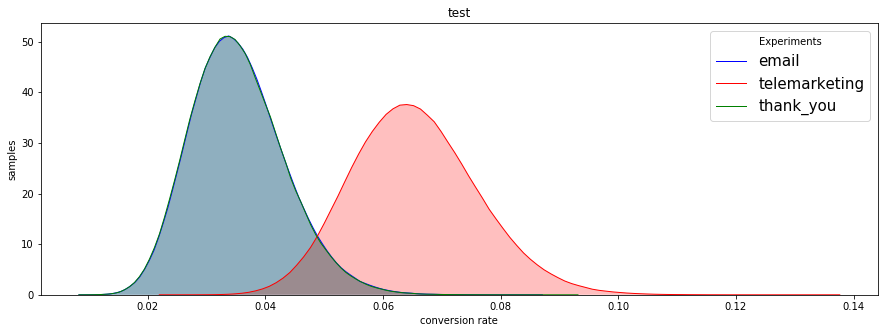

In [110]:
plt.figure(figsize=[15, 5])

colors = ['blue', 'red', 'green', 'gold', 'gray', 'orange', 'orchid', 'teal', 'snow']

for key, val in posteriors.items():
    try:
        color = colors.pop(0)
    except:
        color = 'SteelBlue'     # set color if run out of colors in list provided

    sns.distplot(val, hist=False, kde=True, color=color,
                 kde_kws={'shade': True, 'linewidth': 1},
                 label=key)

plt.legend(prop={'size': 15}, title='Experiments')
plt.title('test')
plt.xlabel('conversion rate')
plt.ylabel('samples')
plt.show()